## Reilly multi-aquifer well example

This is the multi-aquifer well example from Reilly and others (1989).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-maw-p03"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-maw-p03a": {
        "simulation": "regional",
    },
    "ex-gwf-maw-p03b": {
        "simulation": "multi-aquifer well",
    },
    "ex-gwf-maw-p03c": {
        "simulation": "high conductivity",
    },
}


# function to calculate the well connection conductance
def calc_cond(area, l1, l2, k1, k2):
    c1 = area * k1 / l1
    c2 = area * k2 / l2
    return c1 * c2 / (c1 + c2)


# Model parameters
nper = 1  # Number of periods
nlay_r = 21  # Number of layers (regional)
nrow_r = 1  # Number of rows (regional)
ncol_r = 200  # Number of columns (regional)
nlay = 41  # Number of layers (local)
nrow = 16  # Number of rows (local)
ncol = 27  # Number of columns (local)
delr_r = 50.0  # Regional column width ($ft$)
delc_r = 1.0  # Regional row width ($ft$)
top = 10.0  # Top of the model ($ft$)
aq_bottom = -205.0  # Model bottom elevation ($ft$)
strt = 10.0  # Starting head ($ft$)
k11 = 250.0  # Horizontal hydraulic conductivity ($ft/d$)
k33 = 50.0  # Vertical hydraulic conductivity ($ft/d$)
recharge = 0.004566  # Areal recharge ($ft/d$)
H1 = 0.0  # Regional downgradient constant head ($ft$)
maw_loc = (15, 13)  # Row, column location of well
maw_lay = (1, 12)  # Layers with well screen
maw_radius = 0.1333  # Well radius ($ft$)
maw_bot = -65.0  # Bottom of the well ($ft$)
maw_highK = 1e9  # Hydraulic conductivity for well ($ft/d$)

# set delr and delc for the local model
delr = [
    10.0,
    10.0,
    9.002,
    6.0,
    4.0,
    3.0,
    2.0,
    1.33,
    1.25,
    1.00,
    1.00,
    0.75,
    0.50,
    0.333,
    0.50,
    0.75,
    1.00,
    1.00,
    1.25,
    1.333,
    2.0,
    3.0,
    4.0,
    6.0,
    9.002,
    10.0,
    10.0,
]
delc = [
    10,
    9.38,
    9,
    6,
    4,
    3,
    2,
    1.33,
    1.25,
    1,
    1,
    0.75,
    0.5,
    0.3735,
    0.25,
    0.1665,
]

# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

# Define dimensions
extents = (0.0, np.array(delr).sum(), 0.0, np.array(delc).sum())
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# MAW Package boundary conditions
nconn = 2 + 3 * (maw_lay[1] - maw_lay[0] + 1)
maw_packagedata = [[0, maw_radius, maw_bot, strt, "SPECIFIED", nconn]]

# Build the MAW connection data
i, j = maw_loc
obs_elev = {}
maw_conn = []
gwf_obs = []
for k in range(maw_lay[0], maw_lay[1] + 1, 1):
    gwf_obs.append([f"H0_{k}", "HEAD", (k, i, j)])
maw_obs = [
    ["H0", "HEAD", (0,)],
]
iconn = 0
z = -5.0
for k in range(maw_lay[0], maw_lay[1] + 1, 1):
    # connection to layer below
    if k == maw_lay[0]:
        area = delc[i] * delr[j]
        l1 = 2.5
        l2 = 2.5
        cond = calc_cond(area, l1, l2, k33, maw_highK)
        maw_conn.append([0, iconn, k - 1, i, j, top, maw_bot, cond, -999.0])
        tag = f"Q{iconn:02d}"
        obs_elev[tag] = z
        maw_obs.append([tag, "maw", (0,), (iconn,)])
        gwf_obs.append([tag, "flow-ja-face", (k, i, j), (k - 1, i, j)])
        iconn += 1
        z -= 2.5

    # connection to left
    area = delc[i] * 5.0
    l1 = 0.5 * delr[j]
    l2 = 0.5 * delr[j - 1]
    cond = calc_cond(area, l1, l2, maw_highK, k11)
    maw_conn.append([0, iconn, k, i, j - 1, top, maw_bot, cond, -999.0])
    tag = f"Q{iconn:02d}"
    obs_elev[tag] = z
    maw_obs.append([tag, "maw", (0,), (iconn,)])
    gwf_obs.append([tag, "flow-ja-face", (k, i, j), (k, i, j - 1)])
    iconn += 1

    # connection to north
    area = delr[j] * 5.0
    l1 = 0.5 * delc[i]
    l2 = 0.5 * delc[i - 1]
    cond = calc_cond(area, l1, l2, maw_highK, k11)
    maw_conn.append([0, iconn, k, i - 1, j, top, maw_bot, cond, -999.0])
    tag = f"Q{iconn:02d}"
    obs_elev[tag] = z
    maw_obs.append([tag, "maw", (0,), (iconn,)])
    gwf_obs.append([tag, "flow-ja-face", (k, i, j), (k, i - 1, j)])
    iconn += 1

    # connection to right
    area = delc[i] * 5.0
    l1 = 0.5 * delr[j]
    l2 = 0.5 * delr[j + 1]
    cond = calc_cond(area, l1, l2, maw_highK, k11)
    maw_conn.append([0, iconn, k, i, j + 1, top, maw_bot, cond, -999.0])
    tag = f"Q{iconn:02d}"
    obs_elev[tag] = z
    maw_obs.append([tag, "maw", (0,), (iconn,)])
    gwf_obs.append([tag, "flow-ja-face", (k, i, j), (k, i, j + 1)])
    iconn += 1
    z -= 5.0

    # connection to layer below
    if k == maw_lay[1]:
        z += 2.5
        area = delc[i] * delr[j]
        l1 = 2.5
        l2 = 2.5
        cond = calc_cond(area, l1, l2, maw_highK, k33)
        maw_conn.append([0, iconn, k + 1, i, j, top, maw_bot, cond, -999.0])
        tag = f"Q{iconn:02d}"
        obs_elev[tag] = z
        maw_obs.append([tag, "maw", (0,), (iconn,)])
        gwf_obs.append([tag, "flow-ja-face", (k, i, j), (k + 1, i, j)])
        iconn += 1

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-4

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(name, simulation="regional"):
    if simulation == "regional":
        return build_regional(name)
    else:
        return build_local(name, simulation)


def build_regional(name):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    botm = np.arange(-5, aq_bottom - 10.0, -10.0)
    icelltype = [1] + [0 for k in range(1, nlay_r)]
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay_r,
        nrow=nrow_r,
        ncol=ncol_r,
        delr=delr_r,
        delc=delc_r,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        k33=k33,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[0, 0, ncol_r - 1, 0.0]])
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)

    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "LAST")],
        printrecord=[("BUDGET", "LAST")],
    )

    return sim


def build_local(name, simulation):
    # get regional heads for constant head boundaries
    pth = list(parameters.keys())[0]
    fpth = os.path.join(workspace, pth, f"{sim_name}.hds")
    try:
        h = flopy.utils.HeadFile(fpth).get_data()
    except:
        h = np.ones((nlay_r, nrow_r, ncol_r), dtype=float) * strt

    # calculate factor for constant heads
    f1 = 0.5 * (delr_r + delr[0]) / delc_r
    f2 = 0.5 * (delr_r + delr[-1]) / delc_r

    # build chd for model
    regional_range = [k for k in range(nlay_r)]
    local_range = [[0]] + [[k, k + 1] for k in range(1, nlay, 2)]
    chd_spd = []
    for kr, kl in zip(regional_range, local_range):
        h1 = h[kr, 0, 0]
        h2 = h[kr, 0, 1]
        hi1 = h1 + f1 * (h2 - h1)
        h1 = h[kr, 0, 2]
        h2 = h[kr, 0, 3]
        hi2 = h1 + f2 * (h2 - h1)
        for k in kl:
            for il in range(nrow):
                chd_spd.append([k, il, 0, hi1])
                chd_spd.append([k, il, ncol - 1, hi2])

    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)

    botm = np.arange(-5, aq_bottom - 5.0, -5.0)
    icelltype = [1] + [0 for k in range(1, nlay)]
    i, j = maw_loc
    if simulation == "multi-aquifer well":
        k11_sim = k11
        k33_sim = k33
        idomain = np.ones(shape3d, dtype=float)
        for k in range(maw_lay[0], maw_lay[1] + 1, 1):
            idomain[k, i, j] = 0
    else:
        k11_sim = np.ones(shape3d, dtype=float) * k11
        k33_sim = np.ones(shape3d, dtype=float) * k33
        idomain = 1
        for k in range(maw_lay[0], maw_lay[1] + 1, 1):
            k11_sim[k, i, j] = maw_highK
            k33_sim[k, i, j] = maw_highK

    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11_sim,
        k33=k33_sim,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)

    if simulation == "multi-aquifer well":
        maw = flopy.mf6.ModflowGwfmaw(
            gwf,
            no_well_storage=True,
            nmawwells=1,
            packagedata=maw_packagedata,
            connectiondata=maw_conn,
        )
        obs_file = f"{sim_name}.maw.obs"
        csv_file = obs_file + ".csv"
        obs_dict = {csv_file: maw_obs}
        maw.obs.initialize(
            filename=obs_file, digits=10, print_input=True, continuous=obs_dict
        )
    else:
        obs_file = f"{sim_name}.gwf.obs"
        csv_file = obs_file + ".csv"
        obsdict = {csv_file: gwf_obs}
        flopy.mf6.ModflowUtlobs(
            gwf, filename=obs_file, print_input=False, continuous=obsdict
        )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 4.3)
masked_values = (0, 1e30, -1e30)
arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.25, shrinkA=0.1, shrinkB=0.1)


def plot_maw_results(silent=True):
    with styles.USGSPlot():
        # load the observations
        name = list(parameters.keys())[1]
        fpth = os.path.join(workspace, name, f"{sim_name}.maw.obs.csv")
        maw = flopy.utils.Mf6Obs(fpth).data
        name = list(parameters.keys())[2]
        fpth = os.path.join(workspace, name, f"{sim_name}.gwf.obs.csv")
        gwf = flopy.utils.Mf6Obs(fpth).data

        # process heads
        hgwf = 0.0
        ihds = 0.0
        for name in gwf.dtype.names:
            if name.startswith("H0_"):
                hgwf += gwf[name]
                ihds += 1.0
        hgwf /= ihds

        if silent:
            print("MAW head: {}  Average head: {}".format(maw["H0"], hgwf))

        zelev = sorted(list(set(list(obs_elev.values()))), reverse=True)

        results = {
            "maw": {},
            "gwf": {},
        }
        for z in zelev:
            results["maw"][z] = 0.0
            results["gwf"][z] = 0.0

        for name in maw.dtype.names:
            if name.startswith("Q"):
                z = obs_elev[name]
                results["maw"][z] += 2.0 * maw[name]

        for name in gwf.dtype.names:
            if name.startswith("Q"):
                z = obs_elev[name]
                results["gwf"][z] += 2.0 * gwf[name]

        q0 = np.array(list(results["maw"].values()))
        q1 = np.array(list(results["gwf"].values()))
        mean_error = np.mean(q0 - q1)
        if silent:
            print(f"total well inflow:  {q0[q0 >= 0].sum()}")
            print(f"total well outflow: {q0[q0 < 0].sum()}")
            print(f"total cell inflow:  {q1[q1 >= 0].sum()}")
            print(f"total cell outflow: {q1[q1 < 0].sum()}")

        # create the figure
        fig, ax = plt.subplots(
            ncols=1,
            nrows=1,
            sharex=True,
            figsize=(4, 4),
            constrained_layout=True,
        )

        ax.set_xlim(-3.5, 3.5)
        ax.set_ylim(-67.5, -2.5)
        ax.axvline(0, lw=0.5, ls=":", color="0.5")
        for z in np.arange(-5, -70, -5):
            ax.axhline(z, lw=0.5, color="0.5")
        ax.plot(
            results["maw"].values(),
            zelev,
            lw=0.75,
            ls="-",
            color="blue",
            label="Multi-aquifer well",
        )
        ax.plot(
            results["gwf"].values(),
            zelev,
            marker="o",
            ms=4,
            mfc="red",
            mec="black",
            markeredgewidth=0.5,
            lw=0.0,
            ls="-",
            color="red",
            label="High K well",
        )
        ax.plot(
            -1000,
            -1000,
            lw=0.5,
            ls="-",
            color="0.5",
            label="Grid cell",
        )

        styles.graph_legend(ax, loc="upper left", ncol=1, frameon=True)
        styles.add_text(
            ax,
            f"Mean Error {mean_error:.2e} cubic feet per day",
            bold=False,
            italic=False,
            x=1.0,
            y=1.01,
            va="bottom",
            ha="right",
            fontsize=7,
        )

        ax.set_xlabel("Discharge rate, in cubic feet per day")
        ax.set_ylabel("Elevation, in feet")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_regional_grid(silent=True):
    if silent:
        verbosity = 0
    else:
        verbosity = 1
    name = list(parameters.keys())[0]
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation.load(
        sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity
    )
    gwf = sim.get_model(sim_name)

    # get regional heads for constant head boundaries
    h = gwf.output.head().get_data()

    with styles.USGSMap() as fs:
        fig = plt.figure(
            figsize=(6.3, 3.5),
        )
        plt.axis("off")

        nrows, ncols = 10, 1
        axes = [fig.add_subplot(nrows, ncols, (1, 6))]

        # legend axis
        axes.append(fig.add_subplot(nrows, ncols, (7, 10)))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 0})
        ca = mm.plot_array(h, head=h)
        mm.plot_bc("CHD", color="cyan", head=h)
        mm.plot_grid(lw=0.5, color="0.5")
        cv = mm.contour_array(
            h,
            levels=np.arange(0, 6, 0.5),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.1f")
        ax.plot(
            [50, 150, 150, 50, 50],
            [10, 10, aq_bottom, aq_bottom, 10],
            lw=1.25,
            color="#39FF14",
        )
        styles.remove_edge_ticks(ax)
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("Elevation, in feet")

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="none",
            mec="0.5",
            markeredgewidth=0.5,
            label="Grid cell",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="0.5",
            markeredgewidth=0.5,
            label="Constant head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="none",
            mec="#39FF14",
            markeredgewidth=1.25,
            label="Local model domain",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            color="black",
            label="Head contour, $ft$",
        )
        cbar = plt.colorbar(ca, shrink=0.5, orientation="horizontal", ax=ax)
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $ft$", fontsize=9)
        styles.graph_legend(ax, loc="lower center", ncol=4)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-regional-grid.png"
            fig.savefig(fpth)


def plot_local_grid(silent=True):
    if silent:
        verbosity = 0
    else:
        verbosity = 1
    name = list(parameters.keys())[1]
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation.load(
        sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity
    )
    gwf = sim.get_model(sim_name)

    i, j = maw_loc
    dx, dy = delr[j], delc[i]
    px = (
        50.0 - 0.5 * dx,
        50.0 + 0.5 * dx,
    )
    py = (
        0.0 + dy,
        0.0 + dy,
    )

    # get regional heads for constant head boundaries
    h = gwf.output.head().get_data()

    with styles.USGSMap() as fs:
        fig = plt.figure(
            figsize=(6.3, 4.1),
            tight_layout=True,
        )
        plt.axis("off")

        nrows, ncols = 10, 1
        axes = [fig.add_subplot(nrows, ncols, (1, 8))]

        for idx, ax in enumerate(axes):
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(nrows, ncols, (8, 10)))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents, layer=0)
        mm.plot_bc("CHD", color="cyan", plotAll=True)
        mm.plot_grid(lw=0.25, color="0.5")
        cv = mm.contour_array(
            h,
            levels=np.arange(4.0, 5.0, 0.005),
            linewidths=0.5,
            linestyles="-",
            colors="black",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.3f")
        ax.fill_between(
            px, py, y2=0, ec="none", fc="red", lw=0, zorder=200, step="post"
        )
        styles.add_annotation(
            ax,
            text="Well location",
            xy=(50.0, 0.0),
            xytext=(55, 5),
            bold=False,
            italic=False,
            ha="left",
            fontsize=7,
            arrowprops=arrow_props,
        )
        styles.remove_edge_ticks(ax)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_yticks([0, 25, 50])
        ax.set_ylabel("y-coordinate, in feet")

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="0.5",
            markeredgewidth=0.25,
            label="Constant head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="red",
            mec="0.5",
            markeredgewidth=0.25,
            label="Multi-aquifer well",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            color="black",
            label="Water-table contour, $ft$",
        )
        styles.graph_legend(ax, loc="lower center", ncol=3)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-local-grid.png"
            fig.savefig(fpth)


def plot_results(silent=True):
    if not plot:
        return
    plot_regional_grid(silent=silent)
    plot_local_grid(silent=silent)
    plot_maw_results(silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx=0, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Run the regional model.

In [6]:
scenario(0)

run_models took 112.77 ms


Run the local model with MAW well.

In [7]:
scenario(1)

run_models took 212.13 ms


Run the local model with high K well.

In [8]:
scenario(2)

run_models took 213.33 ms


Plot the results.

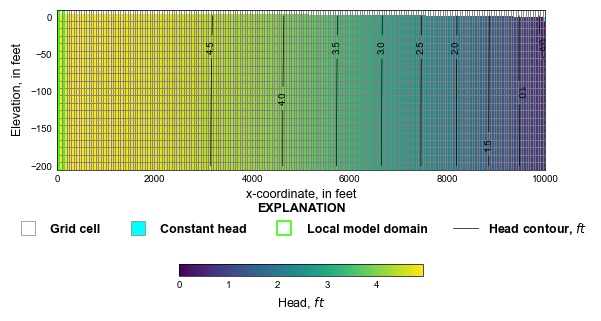

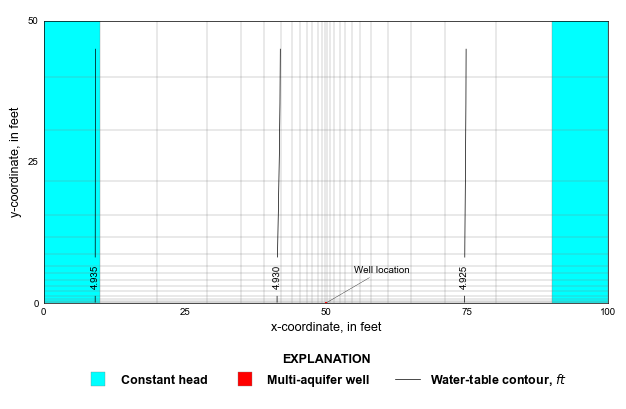

MAW head: [4.92585447]  Average head: [4.92585437]
total well inflow:  9.531058122288
total well outflow: -9.531057706696
total cell inflow:  9.520740053609773
total cell outflow: -9.520739158950668


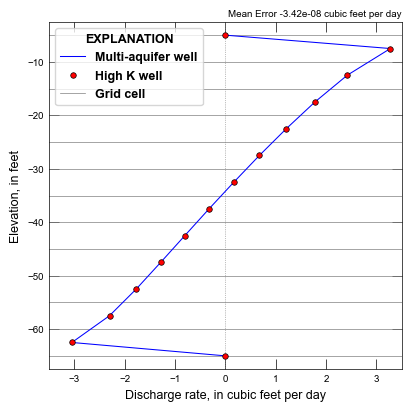

In [9]:
if plot:
    plot_results()